In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

import torch.nn as nn
import torch.nn.functional as F

import torch.optim as optim
import os
from PIL import Image
import numpy as np
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
from torchvision import models
from torchsummary import summary

In [2]:
transform = transforms.Compose(
    [transforms.Resize(size=(100,100)),
     transforms.CenterCrop((100,100)),
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

In [3]:
dataset = torchvision.datasets.ImageFolder(root='./Train pytorch', 
                                            transform=transform)
trainset, testset = torch.utils.data.random_split(dataset, [31367, 7842])

trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=False, num_workers=2)

testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)
classes = ['20', '30', '50', '60', '70','80', 'end 80', '100', '120', 'no overtaking',
           'no overtaking for trucks', 'crossing', 
              'road with priority', 'give the way', 'STOP', 'stops permitted', 'trucks restricted', 
              'no entry', 'caution', 'mind the left turn', 'mind the right turn', 'many turns',
              'ruts', 'slippery road', 'narrowing', 'road maintenance', 'traffic lights',
               'pedestrians crossing', 'chlidren', 'bicycles', 'ice', 'wild animals', 
           'end of caution area','turn right', 'turn left', 'go straight', 'go straight or turn right', 
               'go straight or turn left', 'pass by right side', 'pass by left side', 'roundabout',
               'end of no overtaking', 'end of no overtaking for trucks'
              ]

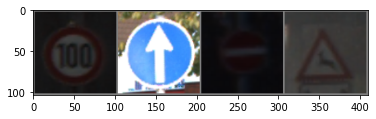

  100 go straight no entry wild animals


In [11]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


dataiter = iter(trainloader)
images, labels = dataiter.next()
imshow(torchvision.utils.make_grid(images))
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

DEFINE NEURAL  NETWORK

In [12]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 22 * 22, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 43)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 22 * 22)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return F.log_softmax(x, dim=1)

In [14]:
net = Net()

In [15]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

TRAINING NETWORK

In [16]:
for epoch in range(2):

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        if i % 2000 == 1999:
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 2.786
[1,  4000] loss: 1.449
[1,  6000] loss: 0.720
[2,  2000] loss: 0.343
[2,  4000] loss: 0.308
[2,  6000] loss: 0.206
Finished Training


In [17]:
PATH = './my pytorch model 2.pth'
torch.save(net.state_dict(), PATH)

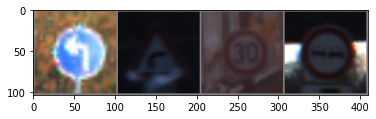

GroundTruth:  turn left mind the right turn    30 no overtaking


In [18]:
dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [19]:
net = Net()
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [21]:
summary(net, (3, 100, 100))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 96, 96]             456
         MaxPool2d-2            [-1, 6, 48, 48]               0
            Conv2d-3           [-1, 16, 44, 44]           2,416
         MaxPool2d-4           [-1, 16, 22, 22]               0
            Linear-5                  [-1, 120]         929,400
            Linear-6                   [-1, 84]          10,164
            Linear-7                   [-1, 43]           3,655
Total params: 946,091
Trainable params: 946,091
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.11
Forward/backward pass size (MB): 0.82
Params size (MB): 3.61
Estimated Total Size (MB): 4.55
----------------------------------------------------------------


In [22]:
outputs = net(images)

In [23]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

Predicted:  turn left mind the right turn    30 no overtaking


In [24]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the test images: 95 %
